In [14]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

In [15]:
met_data_dir = '../Data/MetData'
site = 'Auchencorth Moss'
sites_wtd = {
    'Auchencorth Moss': 'am_wtd.csv',
    'Hare Moss': 'hm_wtd.csv'
}
sites_rain = {
    'Auchencorth Moss': 'am_rainfall.csv',
    'Hare Moss': 'hm_rainfall.csv'
}
perc = 0.87

In [16]:
try: os.chdir(met_data_dir)
except FileNotFoundError: pass

In [17]:
df_wtd_raw = pd.read_csv(sites_wtd[site])
df_rain_raw = pd.read_csv(sites_rain[site])
# df_wtd_raw

In [18]:
dates = np.unique(df_wtd_raw['Date']).tolist()
dates.sort(key = lambda date: datetime.strptime(date, '%d/%m'))
years_wtd = [column for column in list(df_wtd_raw.columns) if column not in ('Date','Time')]
years_rain = [column for column in list(df_rain_raw.columns) if column not in ('Date','Time')]

In [19]:
def get_seasonal_data(df,var):
    dates = np.unique(df['Date']).tolist()
    dates.sort(key = lambda date: datetime.strptime(date, '%d/%m'))
    years_wtd = [column for column in list(df.columns) if column not in ('Date','Time')]

    f_avg = lambda x: f'{var}_avg_{x}'
    f_std = lambda x: f'{var}_std_{x}'

    avg_columns = [f(year) for year in years_wtd for f in (f_avg,f_std)]

    avg_arr = np.zeros((len(dates),len(years_wtd)*2))

    for i in range(len(dates)):
        date = dates[i]
        daily_mean = np.nanmean(df[df['Date'] == date][years_wtd].to_numpy(),axis=0)
        daily_std = np.nanstd(df[df['Date'] == date][years_wtd].to_numpy(),axis=0)
        
        new_row = []
        for j in range(len(daily_mean)):
            new_row.append(daily_mean[j])
            new_row.append(daily_std[j])

        avg_arr[i,:] = new_row
    
    avg_df = pd.DataFrame(avg_arr,index=dates,columns=avg_columns)

    avg_df[f'{var}_avg_overall'] = np.nanmean(avg_df[[f_avg(year) for year in years_wtd]].to_numpy(),axis=1)
    avg_df[f'{var}_std_overall'] = np.nanstd(avg_df[[f_avg(year) for year in years_wtd]].to_numpy(),axis=1)

    return avg_df

In [20]:
avg_wtd_df = get_seasonal_data(df_wtd_raw,'wtd')
avg_rain_df = get_seasonal_data(df_rain_raw,'rain')

C:\Users\s2017658\AppData\Local\Temp\ipykernel_19552\1613867672.py:15: RuntimeWarning: Mean of empty slice
  daily_mean = np.nanmean(df[df['Date'] == date][years_wtd].to_numpy(),axis=0)
c:\Users\s2017658\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\s2017658\AppData\Local\Temp\ipykernel_19552\1613867672.py:15: RuntimeWarning: Mean of empty slice
  daily_mean = np.nanmean(df[df['Date'] == date][years_wtd].to_numpy(),axis=0)
c:\Users\s2017658\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\s2017658\AppData\Local\Temp\ipykernel_19552\1613867672.py:15: RuntimeWarning: Mean of empty slice
  daily_mean = np.nanmean(df[df['Date'] == date][years_wtd].to_nump

In [21]:
seasonal_dict = {
    'Spr': [3,4,5],
    'Sum': [6,7,8],
    'Aut': [9,10,11],
    'Win': [12,1,2],
}

seasonal_wtd_dfs = {}
seasonal_rain_dfs = {}

In [22]:
for season in seasonal_dict:
    seasonal_wtd_dfs[season] = avg_wtd_df.loc[[date for date in avg_wtd_df.index if datetime.strptime(date, "%d/%m").month in seasonal_dict[season]]]
    seasonal_rain_dfs[season] = avg_rain_df.loc[[date for date in avg_rain_df.index if datetime.strptime(date, "%d/%m").month in seasonal_dict[season]]]
# seasonal_wtd_dfs[season]

In [23]:
seasonal_colours = {
    'Aut': '#BF5700', # burnt orange
    'Win': '#4B61D1', # Savoy blue
    'Spr': '#E0B0FF', # mauve
    'Sum': '#50C878', # emerald green
}

Get the upper and lower values corresponding to overall 87% around the 50% percentile. Maybe do so by getting the percentile at 50% - 87%/2 and 50% + 87%/2?

In [24]:
def seasonal_kde_graphs(avg_df,y,seasonal_dfs,perc,unit,label,seasonal_colours,title:str=None,savepath:str=None,ax:plt.Axes=None,rounding:int=1):
    confidence_interval = {}

    if ax == None:
        fig, ax = plt.subplots()

    for season in seasonal_dfs:

        confidence_interval[season] = [np.quantile(seasonal_dfs[season][y],0.5-perc/2),np.quantile(seasonal_dfs[season][y],0.5+perc/2)]
        
        sns.kdeplot(data = seasonal_dfs[season], y = y,ax=ax,c=seasonal_colours[season],label=f'{season} {label} distribution')

        ax.scatter([0,0],confidence_interval[season],s=50,facecolors='none', edgecolors=seasonal_colours[season],clip_on=False,zorder=5,label=f'{season} {int(perc*100)}% confidence interval ({np.round(np.min(confidence_interval[season]),rounding)}$-${np.round(np.max(confidence_interval[season]),rounding)} {unit})')

    yearly_colour = 'gray'
    sns.kdeplot(data = avg_df, y = y,ax=ax,c=yearly_colour,label=f'Yearly {label} distribution',ls='--')
    confidence_interval['Yearly'] = [np.quantile(avg_df[y],0.5-perc/2),np.quantile(avg_df[y],0.5+perc/2)]
    ax.scatter([0,0],confidence_interval['Yearly'],ls='--',s=50,facecolors='none', edgecolors=yearly_colour,clip_on=False,zorder=5,label=f'Yearly {int(perc*100)}% confidence interval ({np.round(np.min(confidence_interval['Yearly']),rounding)}$-${np.round(np.max(confidence_interval['Yearly']),rounding)} {unit})')

    ax.legend(framealpha=1,bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0,fontsize=12)

    
    if title != None:
        ax.set_title(title,fontsize=15)

    if savepath != None:
        fig.savefig(savepath,dpi=600, facecolor = '#fff', bbox_inches='tight')

    return confidence_interval

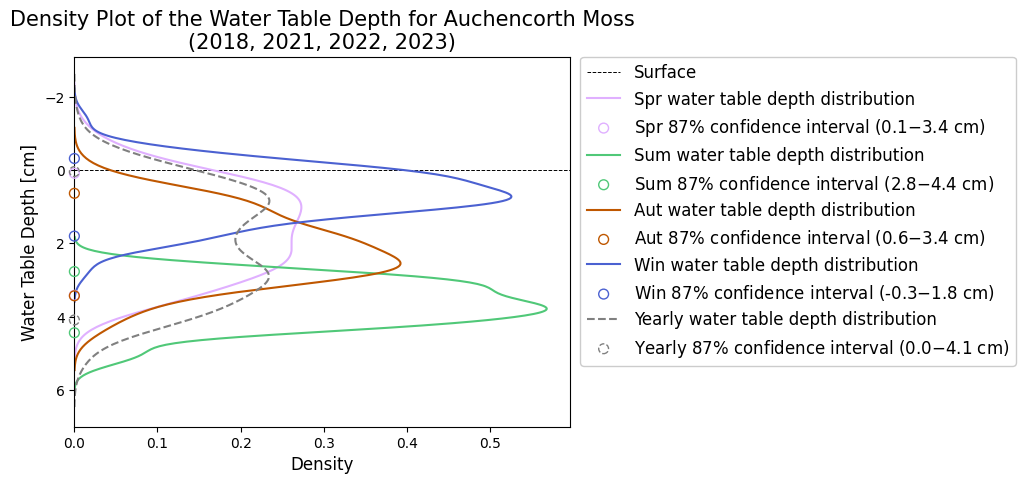

In [25]:
fig_wtd, ax_wtd = plt.subplots()

ax_wtd.set_xlabel('Density')
ax_wtd.set_ylabel('Water Table Depth [cm]')

ax_wtd.axhline(0,ls='--',c='#000',lw=.7,zorder=-5,label='Surface')

years_wtd_str = ''
for y in years_wtd:
    years_wtd_str += y
    if y != years_wtd[-1]: years_wtd_str += ', '
wtd_title = f'Density Plot of the Water Table Depth for {site}\n({years_wtd_str})'

mesotelm_limits = seasonal_kde_graphs(avg_wtd_df,'wtd_avg_overall',seasonal_wtd_dfs,perc,'cm','water table depth',seasonal_colours,title=wtd_title,ax=ax_wtd)

ax_wtd.set_ylim(np.max(ax_wtd.get_ylim()),np.min(ax_wtd.get_ylim()))
ax_wtd.set_xlim(0)

ax_wtd.set_xlabel('Density',fontsize=12)
ax_wtd.set_ylabel('Water Table Depth [cm]',fontsize=12)

fig_wtd.savefig(f"./{site.replace(' ','_').lower()}_wtd.svg",dpi=600, facecolor = '#fff', bbox_inches='tight')

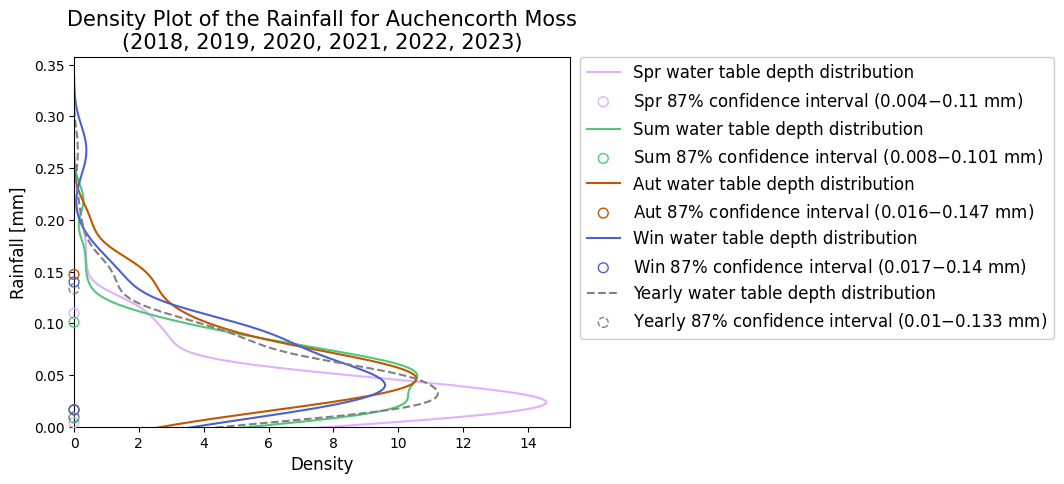

In [27]:
fig_rain, ax_rain = plt.subplots()

ax_rain.set_xlabel('Density')
ax_rain.set_ylabel('Water Table Depth [cm]')

years_rain_str = ''
years_rain_sorted = years_rain.copy()
years_rain_sorted.sort()
for y in years_rain_sorted:
    years_rain_str += y
    if y != years_rain_sorted[-1]: years_rain_str += ', '
rain_title = f'Density Plot of the Rainfall for {site}\n({years_rain_str})'

mesotelm_limits = seasonal_kde_graphs(avg_rain_df,'rain_avg_overall',seasonal_rain_dfs,perc,'mm','water table depth',seasonal_colours,title=rain_title,ax=ax_rain,rounding=3)

# ax_rain.set_ylim(np.max(ax_rain.get_ylim()),np.min(ax_rain.get_ylim()))
ax_rain.set_xlim(0)
ax_rain.set_ylim(0)

ax_rain.set_xlabel('Density',fontsize=12)
ax_rain.set_ylabel('Rainfall [mm]',fontsize=12)

fig_rain.savefig(f"./{site.replace(' ','_').lower()}_rain.svg",dpi=600, facecolor = '#fff', bbox_inches='tight')